In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.7 MB/s eta 0:00:00


In [8]:
import numpy as np
import gymnasium as gym
import random
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

import os
from google.colab import files

In [40]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64, dropout_prob=0.0):
        super().__init__()

        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.activation = nn.ReLU()

    def forward(self, input):
        hidden = self.linear_1(input)
        hidden = self.dropout(hidden)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.dropout(hidden)
        hidden = self.activation(hidden)
        output = self.linear_3(hidden)
        return output

# DQN

In [42]:
class DQN:
    def __init__(self, state_dim, action_n, epsilon_decrease, gamma=0.99, batch_size=128, lr=1e-3, epsilon_min=1e-2):
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_model = Network(self.state_dim, self.action_n).to(device)
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.epsilon = 1
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=lr)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.q_model(state).detach().cpu().numpy()
        max_action = np.argmax(q_values)
        probs = np.ones(self.action_n) * self.epsilon / self.action_n
        probs[max_action] += 1 - self.epsilon
        return np.random.choice(np.arange(self.action_n), p=probs)

    def fit(self, state, action, reward, done, next_state):

        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(
                lambda x: torch.tensor(np.array(x), dtype=torch.float32).to(device),
                zip(*batch)
            )

            targets = rewards + (1 - dones) * self.gamma * torch.max(self.q_model(next_states), dim=1).values
            q_values = self.q_model(states)[torch.arange(self.batch_size), actions.long()]
            loss = torch.mean((q_values - targets) ** 2)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            self.epsilon = max(self.epsilon - self.epsilon_decrease, self.epsilon_min)

# DQN Hard Target Update

In [43]:
class DQN_Hard_Target:
    def __init__(self, state_dim, action_n, epsilon_decrease, gamma=0.99, batch_size=128, lr=1e-3, epsilon_min=1e-2, target_update_freq=100):
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_model = Network(self.state_dim, self.action_n).to(device)
        self.q_target_model = Network(self.state_dim, self.action_n).to(device)
        self.q_target_model.load_state_dict(self.q_model.state_dict())
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.epsilon = 1.0
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=lr)
        self.target_update_freq = target_update_freq
        self.update_count = 0

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.q_model(state).detach().cpu().numpy()
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_n)
        else:
            return np.argmax(q_values)

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(
                lambda x: torch.tensor(np.array(x), dtype=torch.float32).to(device),
                zip(*batch)
            )

            next_q_values = self.q_target_model(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
            targets = rewards + (1 - dones) * self.gamma * max_next_q_values
            q_values = self.q_model(states)[torch.arange(self.batch_size), actions.long()]
            loss = torch.mean((q_values - targets.detach()) ** 2)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.epsilon = max(self.epsilon - self.epsilon_decrease, self.epsilon_min)
            self.update_count += 1

            if self.update_count % self.target_update_freq == 0:
                self.q_target_model.load_state_dict(self.q_model.state_dict())

# DQN Soft Target Update

In [44]:
class DQN_Soft_Target:
    def __init__(self, state_dim, action_n, epsilon_decrease, gamma=0.99, batch_size=128, lr=1e-3, epsilon_min=1e-2, tau=0.01):
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_model = Network(self.state_dim, self.action_n).to(device)
        self.q_target_model = Network(self.state_dim, self.action_n).to(device)
        self.q_target_model.load_state_dict(self.q_model.state_dict())
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.epsilon = 1.0
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=lr)
        self.tau = tau

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.q_model(state).detach().cpu().numpy()
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_n)
        else:
            return np.argmax(q_values)

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(
                lambda x: torch.tensor(np.array(x), dtype=torch.float32).to(device),
                zip(*batch)
            )

            next_q_values = self.q_target_model(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
            targets = rewards + (1 - dones) * self.gamma * max_next_q_values
            q_values = self.q_model(states)[torch.arange(self.batch_size), actions.long()]
            loss = torch.mean((q_values - targets.detach()) ** 2)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.epsilon = max(self.epsilon - self.epsilon_decrease, self.epsilon_min)

            for target_param, param in zip(self.q_target_model.parameters(), self.q_model.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

# Double DQN

In [45]:
class DoubleDQN:
    def __init__(self, state_dim, action_n, epsilon_decrease, gamma=0.99, batch_size=128, lr=1e-3, epsilon_min=1e-2, target_update_freq=100):
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_model = Network(self.state_dim, self.action_n).to(device)
        self.q_target_model = Network(self.state_dim, self.action_n).to(device)
        self.q_target_model.load_state_dict(self.q_model.state_dict())
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.epsilon = 1.0
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=lr)
        self.target_update_freq = target_update_freq
        self.update_count = 0

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.q_model(state).detach().cpu().numpy()
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_n)
        else:
            return np.argmax(q_values)

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(
                lambda x: torch.tensor(np.array(x), dtype=torch.float32).to(device),
                zip(*batch)
            )

            # Double DQN update
            next_q_values = self.q_model(next_states)
            next_actions = torch.argmax(next_q_values, dim=1)
            next_q_target_values = self.q_target_model(next_states)
            max_next_q_values = next_q_target_values[torch.arange(self.batch_size), next_actions]

            targets = rewards + (1 - dones) * self.gamma * max_next_q_values
            q_values = self.q_model(states)[torch.arange(self.batch_size), actions.long()]
            loss = torch.mean((q_values - targets.detach()) ** 2)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.epsilon = max(self.epsilon - self.epsilon_decrease, self.epsilon_min)
            self.update_count += 1

            if self.update_count % self.target_update_freq == 0:
                self.q_target_model.load_state_dict(self.q_model.state_dict())

# Апробация

Алгоритм: DQN, Траектория: 0, Награда: -500.0
Алгоритм: DQN, Траектория: 1, Награда: -500.0
Алгоритм: DQN, Траектория: 2, Награда: -500.0
Алгоритм: DQN, Траектория: 3, Награда: -500.0
Алгоритм: DQN, Траектория: 4, Награда: -500.0
Алгоритм: DQN, Траектория: 5, Награда: -500.0
Алгоритм: DQN, Траектория: 6, Награда: -500.0
Алгоритм: DQN, Траектория: 7, Награда: -500.0
Алгоритм: DQN, Траектория: 8, Награда: -500.0
Алгоритм: DQN, Траектория: 9, Награда: -500.0
Алгоритм: DQN, Траектория: 10, Награда: -500.0
Алгоритм: DQN, Траектория: 11, Награда: -500.0
Алгоритм: DQN, Траектория: 12, Награда: -500.0
Алгоритм: DQN, Траектория: 13, Награда: -500.0
Алгоритм: DQN, Траектория: 14, Награда: -500.0
Алгоритм: DQN, Траектория: 15, Награда: -500.0
Алгоритм: DQN, Траектория: 16, Награда: -500.0
Алгоритм: DQN, Траектория: 17, Награда: -500.0
Алгоритм: DQN, Траектория: 18, Награда: -500.0
Алгоритм: DQN, Траектория: 19, Награда: -500.0
Алгоритм: DQN, Траектория: 20, Награда: -500.0
Алгоритм: DQN, Траектор

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

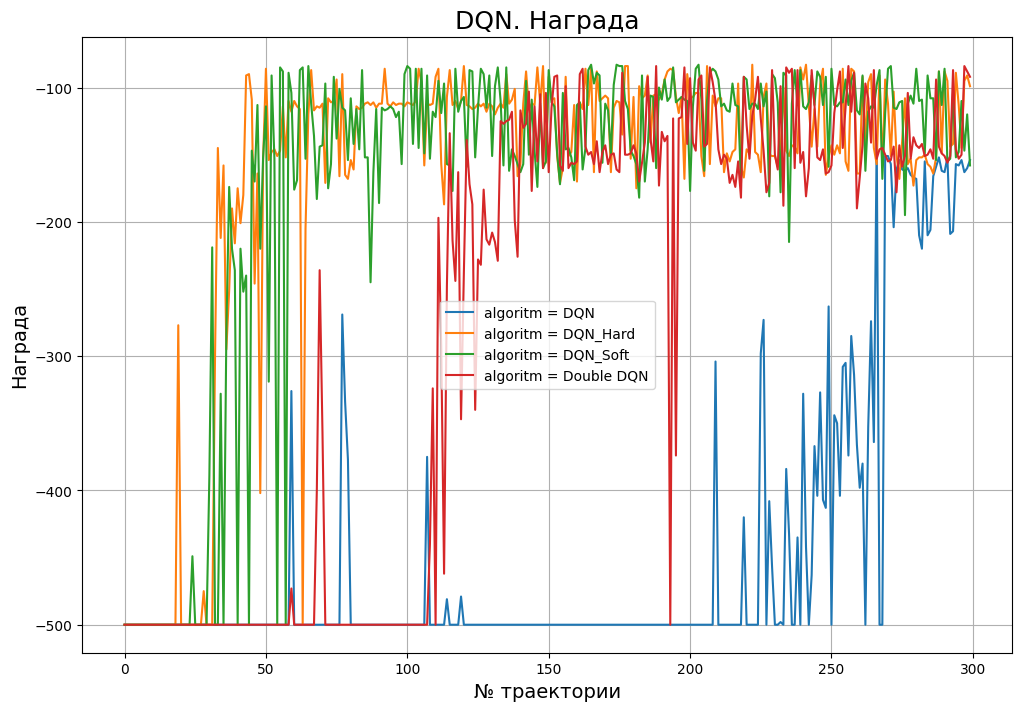

In [47]:
epsilons_decrease = [1e-4]
gammas = [0.99]
batch_sizes = [256]
lrs = [1e-3]
epsilons_min = [1e-2]
trajectorys_n = [300]
trajectorys_len = [500]
target_update_freqs = [50]
taus = [0.1]

type_algos = ['DQN', 'DQN_Hard', 'DQN_Soft', 'Double DQN']

plt.figure(figsize=(12, 8))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for type_algo in type_algos:
  for target_update_freq in target_update_freqs:
    for tau in taus:
      for epsilon_decrease in epsilons_decrease:
        for gamma in gammas:
          for batch_size in batch_sizes:
            for lr in lrs:
              for epsilon_min in epsilons_min:
                for trajectory_n in trajectorys_n:
                  for trajectory_len in trajectorys_len:
                    env = gym.make('MountainCar-v0')
                    state_dim = env.observation_space.shape[0]
                    action_n = env.action_space.n

                    if type_algo == 'DQN':
                      agent = DQN(state_dim, action_n, epsilon_decrease=epsilon_decrease, batch_size=batch_size, lr=lr, epsilon_min=epsilon_min, gamma=gamma)
                    elif type_algo == 'DQN_Hard':
                      agent = DQN_Hard_Target(state_dim, action_n, epsilon_decrease=epsilon_decrease, batch_size=batch_size, lr=lr, epsilon_min=epsilon_min, gamma=gamma, target_update_freq = target_update_freq)
                    elif type_algo == 'DQN_Soft':
                      agent = DQN_Soft_Target(state_dim, action_n, epsilon_decrease=epsilon_decrease, batch_size=batch_size, lr=lr, epsilon_min=epsilon_min, gamma=gamma, tau=tau)
                    else:
                      agent = DoubleDQN(state_dim, action_n, epsilon_decrease=epsilon_decrease, batch_size=batch_size, lr=lr, epsilon_min=epsilon_min, gamma=gamma, target_update_freq = target_update_freq)

                    trajectory_n = trajectory_n
                    trajectory_len = trajectory_len

                    rewards = []

                    for trajectory in range(trajectory_n):
                        total_reward = 0
                        state, _ = env.reset()
                        for t in range(trajectory_len):
                            action = agent.get_action(state)
                            next_state, reward, done, _, _ = env.step(action)
                            total_reward += reward

                            agent.fit(state, action, reward, done, next_state)

                            state = next_state

                            if done:
                                break

                        rewards.append(total_reward)
                        print(f'Алгоритм: {type_algo}, Траектория: {trajectory}, Награда: {total_reward}')

                    sns.lineplot(
                        x=range(len(rewards)),
                        y=rewards,
                        label=f"algoritm = {type_algo}"
                    )

plt.title("DQN. Награда", fontsize=18)
plt.xlabel("№ траектории", fontsize=14)
plt.ylabel("Награда", fontsize=14)
plt.legend()
plt.grid(True)

save_path = "/content"
filename = "graph.png"
plt.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight')
files.download(os.path.join(save_path, filename))

plt.show()